# Gesture Recognition & Desktop Control Notebook

This notebook demonstrates a pipeline to collect hand gesture data, train a neural network model, and use the trained model for real-time desktop control actions. The code is broken down into sections with brief explanations.

# Install required libraries
pip install opencv-python mediapipe tensorflow numpy matplotlib scikit-learn pyautogui pycaw comtypes
# To Solve mediapipe errors
pip install msvc-runtime

In [2]:

# Import necessary libraries
import cv2  # Video capture and image processing
import mediapipe as mp  # Hand tracking
import numpy as np  # Numerical operations
import tensorflow as tf  # Neural network training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import pyautogui  # Desktop control
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume  # Volume control
from comtypes import CLSCTX_ALL
from ctypes import cast, POINTER
import os  # File system management
from sklearn.model_selection import train_test_split  # Data splitting
import matplotlib.pyplot as plt  # Plotting

print("Setup complete! All libraries are imported.")

Setup complete! All libraries are imported.


In [3]:
# Define gestures and create data directory
gestures = ['open_hand', 'fist', 'thumb_up', 'thumb_down', 'peace', 'ok']
data_dir = 'gesture_data'
os.makedirs(data_dir, exist_ok=True)

# Initialize MediaPipe for hand landmark detection
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)


In [4]:
# Data Collection Loop for each gesture
for gesture in gestures:
    gesture_dir = os.path.join(data_dir, gesture)
    os.makedirs(gesture_dir, exist_ok=True)
    print(f'Collecting data for {gesture}. Press "s" to start, "q" to quit.')
    
    cap = cv2.VideoCapture(0)
    # Wait for 's' to start collection
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('Data Collection', frame)
        key = cv2.waitKey(1)
        if key == ord('s'):
            break
        elif key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            raise SystemExit("Stopped by user")
    
    # Collect 100 samples for the current gesture
    count = 0
    while count < 100:
        ret, frame = cap.read()
        if not ret:
            break
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                np.savetxt(os.path.join(gesture_dir, f'{count}.txt'), landmarks)
                count += 1
        cv2.imshow('Data Collection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

print("Data collection complete! All gesture data has been saved.")

Data collection complete! All gesture data has been saved.


In [5]:
# Load and preprocess collected data
X, y = [], []
for label, gesture in enumerate(gestures):
    gesture_dir = os.path.join(data_dir, gesture)
    for file in os.listdir(gesture_dir):
        if file.endswith('.txt'):
            landmarks = np.loadtxt(os.path.join(gesture_dir, file))
            X.append(landmarks)
            y.append(label)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (480, 63)
Testing data shape: (120, 63)


# Model Architecture
Input Layer:
Explicitly defined with a shape of (63,), corresponding to the 63 features (landmark coordinates).

Hidden Layers:

-First Dense Layer: 128 neurons with ReLU activation.

-Dropout Layer: With a rate of 0.5 to reduce overfitting.

-Second Dense Layer: 64 neurons with ReLU activation.

-Dropout Layer: Another dropout for further regularization.

-Output Layer:
A Dense layer with the number of neurons equal to the number of gestures. It uses softmax activation for multi-class classification.

# Model Compilation and Training
-Compilation:
The model is compiled using the Adam optimizer, a sparse categorical crossentropy loss function, and accuracy as a metric.

-Training:
The model is trained for 50 epochs with a batch size of 32. The validation data is used to monitor performance during training.

-Visualization:
After training, the accuracy for both training and validation sets is plotted using Matplotlib.

-Saving the Model:
The trained model is saved to a file named gesture_model.keras.

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2111 - loss: 1.8542 - val_accuracy: 0.3167 - val_loss: 1.7388
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2822 - loss: 1.7281 - val_accuracy: 0.5083 - val_loss: 1.6703
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2813 - loss: 1.6900 - val_accuracy: 0.5500 - val_loss: 1.5986
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4505 - loss: 1.5897 - val_accuracy: 0.5667 - val_loss: 1.5042
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4769 - loss: 1.5383 - val_accuracy: 0.5583 - val_loss: 1.4023
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4902 - loss: 1.4479 - val_accuracy: 0.6583 - val_loss: 1.2941
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5649 - loss: 1.3463 - val_accuracy: 0.6833 - val_loss: 1.1765
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6225 - loss: 1.2637 - val_accuracy: 0.6917 - val_loss

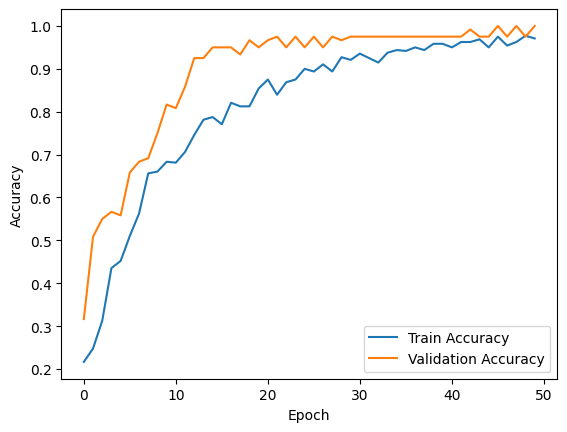

Model training complete! The model has been saved as 'gesture_model.keras'.


In [6]:
# Build and train a simple MLP model
model = Sequential([
    Input(shape=(63,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(gestures), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save('gesture_model.keras')
print("Model training complete! The model has been saved as 'gesture_model.keras'.")

## Real-Time Gesture Recognition and Desktop Interaction
# Model Loading and Re-initialization
-Load Trained Model:
The model is loaded back from the file and recompiled (to ensure all metrics are properly set up).

-Reinitialize MediaPipe:
MediaPipe Hands is reinitialized for real-time hand tracking.

# Main Loop for Real-Time Recognition
-Capture Frame:
Each frame from the webcam is captured and converted from BGR to RGB.

-Hand Landmark Detection:
MediaPipe processes the frame and, if hand landmarks are detected, the landmarks are extracted and reshaped to match the model’s input shape.

-Gesture Prediction:
The model predicts the gesture based on the landmarks. The predicted gesture is determined by finding the index with the highest probability.

# Action Mapping Based on Gesture:

-> open_hand:
The position of the index finger tip is used to control the mouse cursor.
A history of positions (with a window size of 5) is maintained to smooth the cursor movement.
The averaged coordinates are mapped to the screen dimensions, and the cursor is moved accordingly.

-> fist:
A left-click is performed using PyAutoGUI.

-> thumb_up:
The system volume is increased by 5% (capped at 100%).
A temporary message displaying the new volume 
percentage is shown on the video feed.

->thumb_down:
The system volume is decreased by 5% (floored at 0%).
A corresponding volume change message is displayed.

->peace:
The Alt+Tab shortcut is simulated to switch between 
open applications.

->ok:
The Win+D shortcut is simulated to minimize all windows and show the desktop.

# User Interface on the Video Feed:

The current gesture is displayed on the video feed.
Instructions (such as "Press 'q' to quit") are overlaid.
Any temporary messages (e.g., volume change notifications) are displayed for a short duration.

-Exit Condition:
The loop terminates when the user presses the 'q' key.

# Cleanup
After the main loop exits, the following cleanup operations occur:

-The volume control COM object is explicitly released.

-The webcam is released.

-All OpenCV windows are closed.

-A final message confirms that the application has been closed successfully.

In [7]:
# Setup desktop control: screen size and volume control
screen_width, screen_height = pyautogui.size()
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))
print("Desktop controls initialized! Screen size and volume control are set up.")

# Load the trained model
model = tf.keras.models.load_model('gesture_model.keras')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Re-initialize MediaPipe for real-time detection
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# Real-time gesture recognition and desktop control
cap = cv2.VideoCapture(0)
previous_gesture = None
position_history = []
N = 5
volume_message = ""
message_timer = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    gesture = None
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            landmarks = np.array(landmarks).reshape(1, -1)
            prediction = model.predict(landmarks, verbose=0)
            gesture_idx = np.argmax(prediction)
            gesture = gestures[gesture_idx]
            
            if gesture == 'open_hand':
                index_tip = hand_landmarks.landmark[8]
                hand_x = 1 - index_tip.x
                hand_y = index_tip.y
                position_history.append((hand_x, hand_y))
                if len(position_history) > N:
                    position_history.pop(0)
                avg_x = sum(p[0] for p in position_history) / len(position_history)
                avg_y = sum(p[1] for p in position_history) / len(position_history)
                screen_x = avg_x * screen_width
                screen_y = avg_y * screen_height
                pyautogui.moveTo(screen_x, screen_y)
            elif gesture != previous_gesture:
                if gesture == 'fist':
                    pyautogui.click()
                    print("Action: Left-click")
                elif gesture == 'thumb_up':
                    current_volume = volume.GetMasterVolumeLevelScalar()
                    new_volume = min(current_volume + 0.05, 1.0)
                    volume.SetMasterVolumeLevelScalar(new_volume, None)
                    volume_message = f"Volume Up: {int(new_volume*100)}%"
                    message_timer = 30
                    print(volume_message)
                elif gesture == 'thumb_down':
                    current_volume = volume.GetMasterVolumeLevelScalar()
                    new_volume = max(current_volume - 0.05, 0.0)
                    volume.SetMasterVolumeLevelScalar(new_volume, None)
                    volume_message = f"Volume Down: {int(new_volume*100)}%"
                    message_timer = 30
                    print(volume_message)
                elif gesture == 'peace':
                    pyautogui.hotkey('alt', 'tab')
                    print("Action: Switched applications")
                elif gesture == 'ok':
                    pyautogui.hotkey('win', 'd')
                    print("Action: Showed desktop")
            previous_gesture = gesture
    
    cv2.putText(frame, f'Gesture: {gesture if gesture else "None"}', (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, 'Press "q" to quit', (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    if message_timer > 0:
        cv2.putText(frame, volume_message, (10, 90), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
        message_timer -= 1
    cv2.imshow('Gesture Control', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

volume.Release()
cap.release()
cv2.destroyAllWindows()
print("Application closed successfully!")

Desktop controls initialized! Screen size and volume control are set up.
Volume Up: 87%
Action: Left-click
Volume Down: 82%
Volume Up: 87%
Action: Left-click
Volume Up: 92%
Action: Left-click
Action: Showed desktop
Action: Left-click
Action: Showed desktop
Action: Left-click
Action: Switched applications
Volume Up: 98%
Action: Switched applications
Volume Up: 100%
Action: Left-click
Action: Switched applications
Action: Left-click
Action: Left-click
Action: Showed desktop
Action: Showed desktop
Action: Showed desktop
Action: Showed desktop
Action: Showed desktop
Action: Left-click
Volume Down: 95%
Action: Showed desktop
Application closed successfully!


## Evaluation: Model Accuracy and Processing Latency

The following cell evaluates the trained model on the test dataset and measures the latency of processing a single frame.

In [8]:
import time

# Evaluate model accuracy on the test dataset
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Measure latency of processing one frame
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()
if ret:
    start_time = time.time()
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            landmarks = np.array(landmarks).reshape(1, -1)
            prediction = model.predict(landmarks, verbose=0)
    end_time = time.time()
    latency = (end_time - start_time) * 1000  # Convert to milliseconds
    print("Processing Latency: {:.2f} ms".format(latency))
else:
    print("Could not capture a frame for latency measurement.")

Test Accuracy: 100.00%
Processing Latency: 16.37 ms


# Summary
This code implements a full pipeline for gesture recognition and desktop control:

-Data Collection: Capture and save hand landmark data for multiple gestures.

-Model Training: Train an MLP on the collected data.

-Real-Time Application: Load the trained model, recognize gestures in real time, and perform desktop actions (such as moving the cursor, clicking, switching applications, and adjusting volume).